# Time Series Clustering

Steps:
- Data Collection and Preprocessing
- Feature Extraction
- Choosing a Distance Metric
- Clustering Algorithm
- Evaluation


## Import Libraries

In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from abc import ABC, abstractmethod
from tqdm import tqdm
from tslearn.metrics import dtw
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

/mnt/zkpet/venv/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
seed = 42

random.seed(seed)
np.random.seed(seed) 
torch.manual_seed(seed)   

## Data Collection and Preprocessing

In [3]:
set_type = 0
scaler = StandardScaler()
df_raw = pd.read_csv('dataset/electricity.csv')


num_train = int(len(df_raw)*4/5)
num_test = int(len(df_raw)*1/10)
num_vali = len(df_raw) - num_train - num_test         

border1s = [0, num_train, -num_test]
border2s = [num_train, num_train+num_vali, len(df_raw)]
border1 = border1s[set_type]
border2 = border2s[set_type]

cols_data = df_raw.columns[1:] # remove date column
df_data = df_raw[cols_data]

train_data = df_data[border1s[0]:border2s[0]]
scaler.fit(train_data.values)
data = scaler.transform(df_data.values)
data_x = data[border1:border2].astype(np.float32)

x = torch.tensor(data_x.transpose())

In [4]:
x.shape

torch.Size([321, 21043])

## Feature Extraction

In [5]:
class TrendExtractor(nn.Module, ABC):
    def __init__(self, channels, kernel_size) -> None:
        super().__init__()
        
        self.channels = channels
        self.kernel_size = kernel_size
        self.conv = nn.Conv1d(channels, channels, kernel_size, groups=channels, bias=False)
        self.init_weights()

        
    @abstractmethod
    def init_weights(self):
        '''initialize the weights of the convolution kernel'''
        pass

        
    def forward(self, x):
        '''x: raw time series of shape: (N:num_channels, L:length)'''
        return self.conv(x)
    


class MovingAverage(TrendExtractor):
    def init_weights(self):
        self.conv.weight.data.fill_(1.0/self.kernel_size)



def tricube(x):
    return (1 - abs(x)**3)**3 if abs(x) <= 1 else 0 
    
class LoessApprox(TrendExtractor):
    def init_weights(self):
        distances = torch.linspace(-1, 1, self.kernel_size)
        weights = torch.tensor([tricube(d) for d in distances])
        normalized_weights = weights / torch.sum(weights)
        kernel = normalized_weights.reshape(1, 1, -1).repeat(self.channels, 1, 1)
        self.conv.weight.data = kernel
        
        
        
class SeasonalExtractor(nn.Module):
    def __init__(self, period, kernel_blocks, stride_blocks) -> None:
        super().__init__()
        
        self.period = period
        self.kernel_blocks = kernel_blocks
        self.stride_blocks = stride_blocks
        
        
    def forward(self, x):
        '''x: detrended time series of shape: (N:num_channels, L:length)'''
        r = (x.shape[1] - self.kernel_blocks * self.period) % (self.stride_blocks * self.period)
        x_trimmed = x[:, r:]
        unfold_x = x_trimmed.unfold(1, self.kernel_blocks * self.period, self.stride_blocks * self.period)
        unfold_x_reshaped = unfold_x.reshape(unfold_x.size(0), unfold_x.size(1), self.kernel_blocks, self.period)
        seasonal = unfold_x_reshaped.mean(2).flatten(1)

        return seasonal
    
    

class DecompositionEncoder(nn.Module):
    def __init__(self, channels, trend_kernel_size, trend_downsampling_rate, period, seasonal_window_blocks, seasonal_stride_blocks, trend_model='MovingAverage') -> None:
        super().__init__()
            
        self.trend_extractor = {'MovingAverage': MovingAverage,
                           'LoessApprox': LoessApprox}[trend_model](channels, trend_kernel_size)
        self.padding = trend_kernel_size // 2
        self.downsampling_rate = trend_downsampling_rate
        self.seasonal_extractor = SeasonalExtractor(period, seasonal_window_blocks, seasonal_stride_blocks)
                    
    
    def forward(self, x):
        '''x: raw time series of shape: (N:num_channels, L:length)'''  
        trend = self.trend_extractor(x)
        detrend = x[:, self.padding: -self.padding] - trend
        seasonal = self.seasonal_extractor(detrend)
        
        return trend[:,::self.downsampling_rate], seasonal
        

In [6]:
enc_model = DecompositionEncoder(channels = x.shape[0],
                                 trend_kernel_size = 4 * 7 * 24 + 1,
                                 trend_downsampling_rate = 7 * 24,
                                 period = 24,
                                 seasonal_window_blocks = 180,
                                 seasonal_stride_blocks = 60,
                                 trend_model='MovingAverage')
trend, seasonal = enc_model(x)

In [7]:
trend.shape, seasonal.shape

(torch.Size([321, 122]), torch.Size([321, 288]))

## Choosing a Distance Metric

In [8]:
def compute_distance_matrix(x):
    num_series = x.shape[0]
    distance_matrix = np.zeros((num_series, num_series))
    
    for i in tqdm(range(num_series)):
        for j in range(i + 1, num_series):
            distance = dtw(x[i], x[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
            
    return distance_matrix

100%|██████████| 321/321 [00:05<00:00, 62.09it/s] 


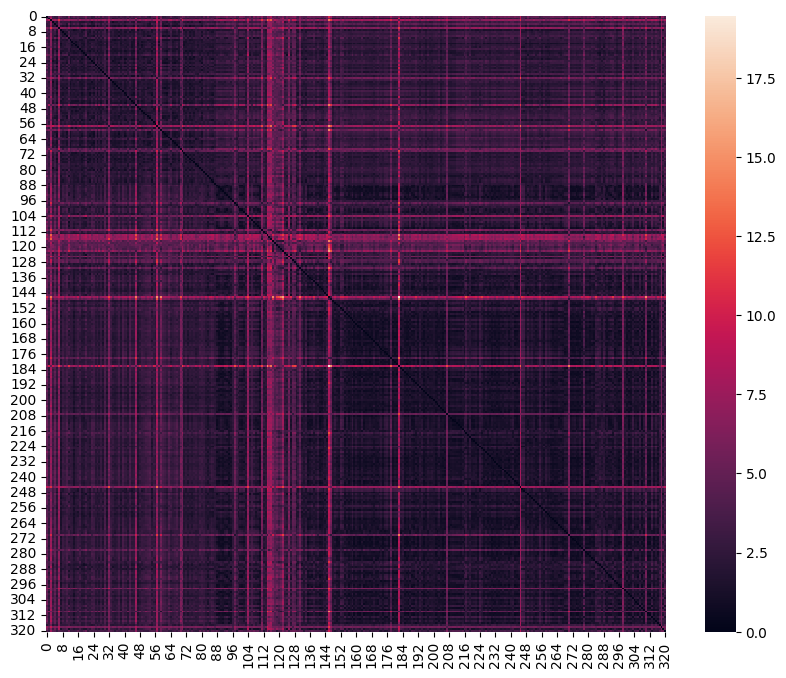

In [9]:
trend_dist_matrix = compute_distance_matrix(trend.detach().numpy())
plt.figure(figsize=(10, 8))
sns.heatmap(trend_dist_matrix)
plt.show()

100%|██████████| 321/321 [00:15<00:00, 20.29it/s]


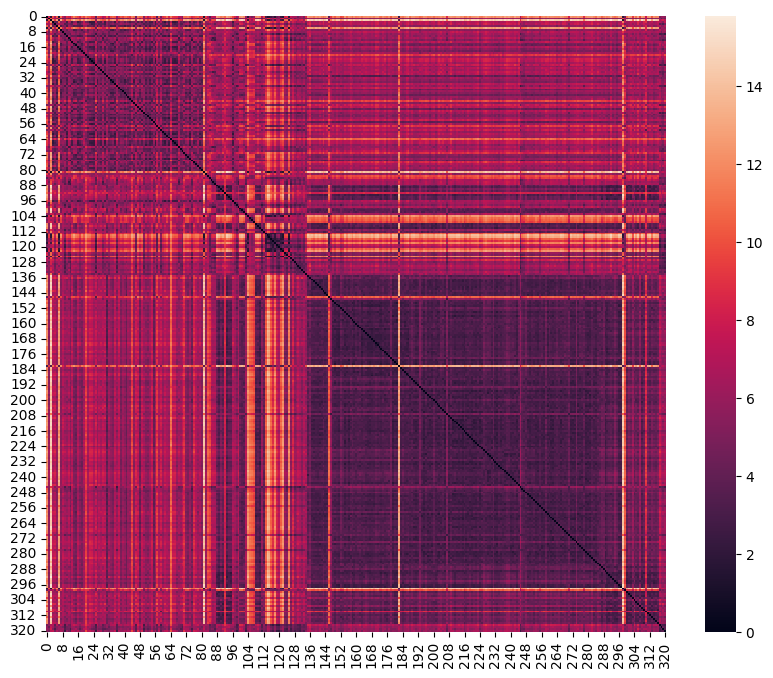

In [10]:
seasonal_dist_matrix = compute_distance_matrix(seasonal.detach().numpy())
plt.figure(figsize=(10, 8))
sns.heatmap(seasonal_dist_matrix)
plt.show()

## Clustering Algorithm

### K-Mediods

100%|██████████| 19/19 [00:00<00:00, 19.18it/s]


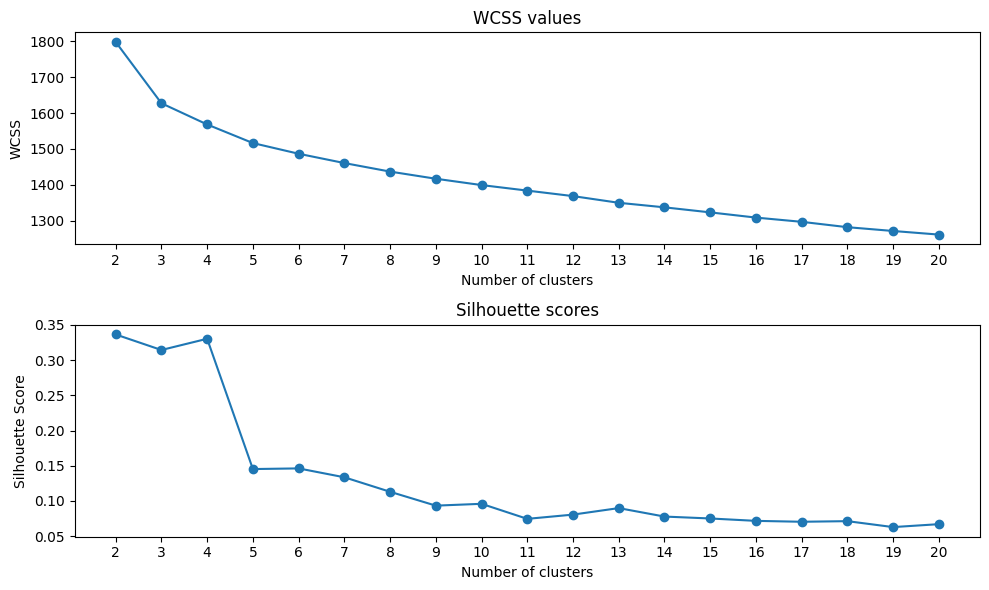

In [11]:
dist_matrix = trend_dist_matrix + seasonal_dist_matrix

wcss = []
silhouette_scores = []
clusters = range(2, 21)
for n_clusters in tqdm(clusters):  # Testing 2 to 20 clusters
    kmedoids = KMedoids(n_clusters, metric='precomputed', random_state=seed, method='pam')
    kmedoids.fit(dist_matrix)
    cluster_labels = kmedoids.labels_
    wcss.append(kmedoids.inertia_)
    silhouette_scores.append(silhouette_score(dist_matrix, cluster_labels, metric='precomputed', random_state=seed))
    

fig, axs = plt.subplots(2, figsize=(10, 6))

# Plot WCSS values
axs[0].plot(list(clusters), wcss, marker='o')

axs[0].set_title('WCSS values')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('WCSS')
axs[0].set_xticks(list(clusters))


# Plot silhouette scores
axs[1].plot(list(clusters), silhouette_scores, marker='o')
axs[1].set_title('Silhouette scores')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Silhouette Score')
axs[1].set_xticks(list(clusters))

plt.tight_layout()
plt.show()

Based on the above results it seems like n_clusters = 4 is a good choice.

In [12]:
kmedoids = KMedoids(n_clusters=4, metric='precomputed', random_state=seed, method='pam')
kmedoids.fit(dist_matrix)
cluster_labels = kmedoids.labels_
cluster_labels

array([0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 1, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 3, 3, 3, 1, 0, 1, 1, 1, 3, 3,
       3, 1, 3, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3,

## Evaluation

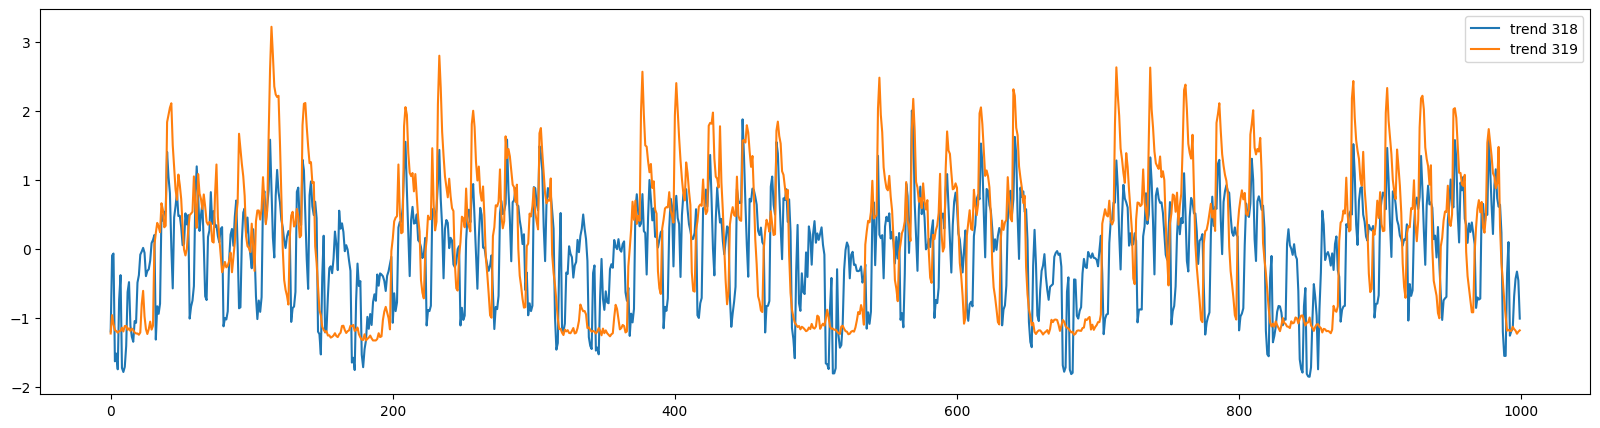

In [15]:
i, j = 318, 319 

plt.figure(figsize=(20, 5))
plt.plot(x[i,:1000].detach().numpy(), label=f'trend {i}')
plt.plot(x[j,:1000].detach().numpy(), label=f'trend {j}')
plt.legend()
plt.show()

## Questions
1. The decomposition encoding requires a centralized data set to calculate trend and seasonal matrics. How to ensure privacy in this case? 
 <br />Can this encoder be implemented in a distributed way?
2. Is this clustering algorithm dynamic enough to handle individual electricity usage pattern changes and new comers/leavers? 

In [2]:
import numpy as np

cluster_labels = np.array([0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 1, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 3, 3, 3, 1, 0, 1, 1, 1, 3, 3,
       3, 1, 3, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1])

In [3]:
cluster = {} # dict of {label: idx array}
n_clusters = 4
for n in range(n_clusters):
  idx_list = np.where(cluster_labels == n)[0]
  cluster[n] = idx_list
  print(len(idx_list))
cluster

17
51
63
190


{0: array([  0,   2,   6,  81, 104, 114, 115, 116, 117, 118, 119, 121, 122,
        125, 146, 182, 298]),
 1: array([  1,   9,  11,  12,  19,  25,  29,  36,  46,  50,  57,  59,  68,
         70,  75,  83,  84,  85,  86,  87,  97,  98,  99, 103, 105, 106,
        107, 111, 113, 120, 123, 124, 126, 127, 128, 129, 130, 131, 132,
        133, 147, 207, 245, 246, 270, 299, 310, 317, 318, 319, 320]),
 2: array([  3,   4,   5,   7,   8,  10,  13,  14,  15,  16,  17,  18,  20,
         21,  22,  23,  24,  26,  27,  28,  30,  32,  33,  34,  35,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  47,  48,  49,  51,  52,
         53,  54,  56,  58,  60,  61,  62,  63,  64,  65,  66,  67,  69,
         71,  72,  74,  76,  77,  78,  79,  80,  82,  96, 134]),
 3: array([ 31,  55,  73,  88,  89,  90,  91,  92,  93,  94,  95, 100, 101,
        102, 108, 109, 110, 112, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 16